In [ ]:
import torch
import sys
import numpy as np
import os
from glob import glob


device = torch.device("cpu")

file_path = "results/feasible-lake/map_circular_4_19/grid_length_7/activations/test/grid_observations_10/episode_1/activation_grid_observations_10_block_0.pt"
root_dir = "results/feasible-lake/map_circular_4_19/grid_length_7/activations"

# test loading the file
try:
    data = torch.load(file_path, map_location="cpu")
    print(f"Loaded type: {type(data)}")
    if isinstance(data, dict):
        print(f"Keys: {data.keys()}")
    elif isinstance(data, torch.Tensor):
        print(f"Tensor shape: {data.shape}")
    else:
        print("Loaded data:", data)
except Exception as e:
    print(f"Error loading file: {e}")


# read .pt files
activation_files = sorted(glob(os.path.join(root_dir, "**/*.pt"), recursive=True))
print(f"Found {len(activation_files)} activation files")

/tmp/ipykernel_59745/77453416.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path, map_location="cpu")


Loaded type: <class 'torch.Tensor'>
Tensor shape: torch.Size([332, 30, 196])
Found 24 activation files


In [ ]:
import torch
import os
import numpy as np
import re
from glob import glob
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Regex pattern to extract grid observation and step
pattern = re.compile(r'grid_observations_(\d+)/episode_(\d+)/activation_grid_observations_\d+_block_(\d+).pt')

# Store activations and metadata
activation_data = []  # List of tuples (activations, grid_observation, step, block)
num_grids = []

for file in activation_files:
    match = pattern.search(file)
    if match:
        grid_observation = int(match.group(1))
        episode = int(match.group(2))
        block = int(match.group(3))
        
        
        # Load activation tensor
        tensor = torch.load(file, map_location="cpu")
        tensor = tensor.detach().numpy()  # Shape (40, 30, 196)

        # Store activations with metadata
        activation_data.append((tensor, grid_observation, episode, block))
        num_grids.append(grid_observation)  # Append grid observation to num_grids

# number of grids is equal to the number of unique grid_observation values
num_grids = len(set(num_grids))

print("Num grids:", num_grids)
# Convert to a structured NumPy array
all_activations = np.concatenate([data[0] for data in activation_data], axis=0)  # Shape (N, 30, 196)
metadata = []
for data in activation_data:
    grid_observation, episode, block = data[1], data[2], data[3]
    metadata.extend([(grid_observation, episode, block)] * data[0].shape[0])  # Repeat for all activations


print(f"Combined activations shape: {all_activations.shape}")
print(f"Metadata count: {len(metadata)}")  # Should match the number of activations

# Reshape for clustering
X = all_activations.reshape(all_activations.shape[0], -1)  # Shape (N, 5880)

print(f"Reshaped activations for clustering: {X.shape}")


/tmp/ipykernel_59745/3248784493.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(file, map_location="cpu")


Num grids: 2
Combined activations shape: (11184, 30, 196)
Metadata count: 11184
Reshaped activations for clustering: (11184, 5880)


In [23]:
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X)

In [24]:
n_clusters = num_grids
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_pca)

# Store cluster results with metadata
cluster_results = [(metadata[i][0], metadata[i][1], metadata[i][2], labels[i]) for i in range(len(metadata))]

# Print some sample results
for i in range(5):
    print(f"Grid {cluster_results[i][0]}, Episode {cluster_results[i][1]}, Block {cluster_results[i][2]} -> Cluster {cluster_results[i][3]}")


Grid 10, Episode 1, Block 0 -> Cluster 0
Grid 10, Episode 1, Block 0 -> Cluster 0
Grid 10, Episode 1, Block 0 -> Cluster 0
Grid 10, Episode 1, Block 0 -> Cluster 0
Grid 10, Episode 1, Block 0 -> Cluster 0


[10 10 10 ... 47 47 47]


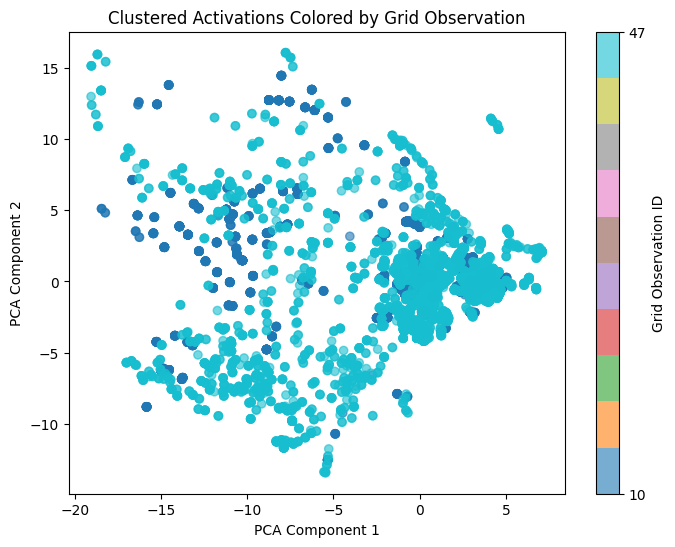

In [ ]:
# Extract grid observation IDs for coloring
grid_obs_ids = np.array([meta[0] for meta in metadata[:X_pca.shape[0]]])  # Ensure length matches
print(grid_obs_ids)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=grid_obs_ids, cmap='tab10', alpha=0.6)

# Adjust colorbar for discrete values
cbar = plt.colorbar(scatter, ticks=np.unique(grid_obs_ids))
cbar.set_label("Grid ID")
cbar.ax.set_yticklabels(np.unique(grid_obs_ids))  # Ensure labels match unique IDs

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clustered Activations Colored by Grid ID")
plt.show()